# Model Validation Notebook

Rigorous statistical validation of 7 IVS models against market data.

**Models:** MLP, MLP-log, Conv, Conv-log, MLP-log-arb, Conv-log-arb, Heston  
**Sections:**
0. Config & Load & Align
1. Error Distribution Analysis
2. Signed Bias (Mean-Error Heatmaps)
3. MAPE / Relative Error
4. KS Test Per-Cell (Distributional Fit)
5. Diebold-Mariano Pairwise Significance
6. Backtesting (Exceedance + Kupiec POF + Traffic Light)
7. Regime Conditioning
8. Arbitrage Violation Counting
9. Surface Smoothness

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import json
from pathlib import Path
from collections import OrderedDict
from scipy import stats

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (12, 6)

# ── Output directory ──
OUT = Path("../../artifacts/validation/arb_penalty")
OUT.mkdir(parents=True, exist_ok=True)
(OUT / "plots").mkdir(exist_ok=True)
(OUT / "tables").mkdir(exist_ok=True)
print(f"Artifacts → {OUT.resolve()}")

Artifacts → C:\Users\Admin\OneDrive\Desktop\Fifth Year\Computer Science\CS4490 Thesis\Codebase\Thesis\artifacts\validation\arb_penalty


## §0  Configuration & Data Loading

In [20]:
TICKER = "AAPL"

# ── Model directories ──
VAE_DIRS = OrderedDict([
    ("MLP",          Path("../../artifacts/eval/mlp/surfaces")),
    ("MLP-log",      Path("../../artifacts/eval/mlp_log/surfaces")),
    ("Conv",         Path("../../artifacts/eval/conv/surfaces")),
    ("Conv-log",     Path("../../artifacts/eval/conv_log/surfaces")),
    ("MLP-log-arb",  Path("../../artifacts/eval/mlp_log_arb/surfaces")),
    ("Conv-log-arb", Path("../../artifacts/eval/conv_log_arb/surfaces")),
])
HESTON_DIR = Path("../../data/processed/heston/surfaces")

COLOURS = {
    "MLP": "#1f77b4", "MLP-log": "#9467bd",
    "Conv": "#2ca02c", "Conv-log": "#8c564b",
    "MLP-log-arb": "#d62728", "Conv-log-arb": "#e377c2",
    "Heston": "#ff7f0e",
}
MODEL_NAMES = list(COLOURS.keys())  # fixed order for all analyses

# ── Load VAE surfaces ──
vae_surfaces = {}
grid_spec = None
for name, sdir in VAE_DIRS.items():
    model_s = np.load(sdir / "vae_surfaces.npy")
    market_s = np.load(sdir / "market_surfaces.npy")
    dates_s = pd.to_datetime(pd.read_csv(sdir / "vae_surface_dates.csv")["date"])
    vae_surfaces[name] = (model_s, market_s, dates_s)
    if grid_spec is None:
        with open(sdir / "grid_spec.json") as f:
            grid_spec = json.load(f)
    print(f"✓ {name:<14} {model_s.shape}  ({len(dates_s)} dates)")

# ── Load Heston ──
heston_surf = np.load(HESTON_DIR / f"{TICKER}_heston_surfaces.npy")
heston_dates = pd.to_datetime(
    pd.read_csv(HESTON_DIR / f"{TICKER}_heston_surface_dates.csv")["date"]
)
print(f"✓ {'Heston':<14} {heston_surf.shape}  ({len(heston_dates)} dates)")

# ── Grid info ──
days_grid = np.array(grid_spec["days_grid"])
delta_grid = np.array(grid_spec["delta_grid"])
cp_labels = grid_spec["cp_order"]  # ['C', 'P']
n_chan, n_mat, n_del = len(cp_labels), len(days_grid), len(delta_grid)
print(f"\nGrid: {cp_labels} × {n_mat} maturities × {n_del} deltas")

✓ MLP            (244, 2, 11, 17)  (244 dates)
✓ MLP-log        (244, 2, 11, 17)  (244 dates)
✓ Conv           (244, 2, 11, 17)  (244 dates)
✓ Conv-log       (244, 2, 11, 17)  (244 dates)
✓ MLP-log-arb    (244, 2, 11, 17)  (244 dates)
✓ Conv-log-arb   (244, 2, 11, 17)  (244 dates)
✓ Heston         (210, 2, 11, 17)  (210 dates)

Grid: ['C', 'P'] × 11 maturities × 17 deltas


In [21]:
# ── Align to common dates ──
def _to_date_set(ds):
    return set(ds.dt.date)

first_name = next(iter(vae_surfaces))
common = _to_date_set(vae_surfaces[first_name][2])
for name, (_, _, dates) in vae_surfaces.items():
    common &= _to_date_set(dates)
common &= _to_date_set(heston_dates)
common = sorted(common)
N = len(common)

# Build aligned arrays  ──  shape (N, 2, 11, 17)
models = OrderedDict()
for name, (surf, _, dates) in vae_surfaces.items():
    mask = [d in common for d in dates.dt.date]
    models[name] = surf[mask]

heston_mask = [d in common for d in heston_dates.dt.date]
models["Heston"] = heston_surf[heston_mask]

# Market ground truth (same for all VAEs — verified identical)
first_vae = next(iter(vae_surfaces.values()))
market_mask = [d in common for d in first_vae[2].dt.date]
market = first_vae[1][market_mask]
aligned_dates = first_vae[2][market_mask].reset_index(drop=True)

# ── NaN mask (Heston only has NaNs) ──
# valid_mask: True where ALL models AND market have finite values
valid_mask = np.isfinite(market)
for name, surf in models.items():
    valid_mask &= np.isfinite(surf)

pct_valid = 100 * valid_mask.sum() / valid_mask.size
print(f"Common dates : {N}")
print(f"Date range   : {common[0]}  →  {common[-1]}")
print(f"Valid cells   : {valid_mask.sum():,} / {valid_mask.size:,} ({pct_valid:.1f}%)")

# ── Precompute errors (raw & absolute)  ──  only at valid cells
errors = OrderedDict()     # name → flat array of (model − market) at valid cells
abs_errors = OrderedDict()
for name, surf in models.items():
    e = (surf - market)            # signed error
    err_flat = e[valid_mask]
    errors[name] = err_flat
    abs_errors[name] = np.abs(err_flat)
    print(f"  {name:<14} MAE={np.abs(err_flat).mean()*100:.2f} vol pts   "
          f"RMSE={np.sqrt((err_flat**2).mean())*100:.2f} vol pts")

Common dates : 210
Date range   : 2024-09-10  →  2025-08-29
Valid cells   : 78,072 / 78,540 (99.4%)
  MLP            MAE=1.13 vol pts   RMSE=1.62 vol pts
  MLP-log        MAE=1.09 vol pts   RMSE=1.72 vol pts
  Conv           MAE=1.11 vol pts   RMSE=1.61 vol pts
  Conv-log       MAE=1.13 vol pts   RMSE=1.73 vol pts
  MLP-log-arb    MAE=1.11 vol pts   RMSE=1.63 vol pts
  Conv-log-arb   MAE=1.24 vol pts   RMSE=1.74 vol pts
  Heston         MAE=2.28 vol pts   RMSE=8.17 vol pts


## §1  Error Distribution Analysis

Histograms, QQ-plots, and percentile tables for the signed error $(\\hat{\\sigma} - \\sigma_{\\text{mkt}})$ across all valid cells.

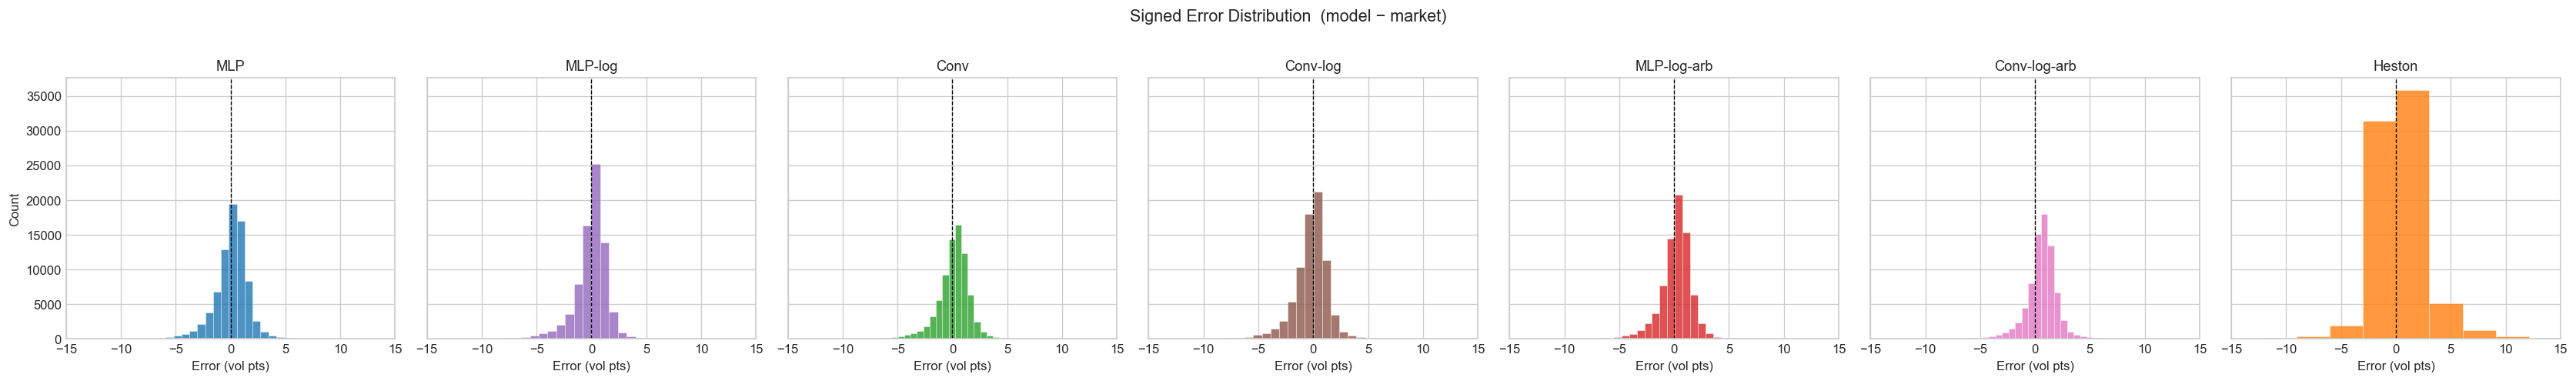

In [22]:
# ── 1a. Signed-error histograms ──
fig, axes = plt.subplots(1, len(MODEL_NAMES), figsize=(4*len(MODEL_NAMES), 4), sharey=True)
for ax, name in zip(axes, MODEL_NAMES):
    e = errors[name] * 100  # → vol points
    ax.hist(e, bins=80, color=COLOURS[name], alpha=0.8, edgecolor="white", linewidth=0.3)
    ax.axvline(0, color="k", ls="--", lw=0.8)
    ax.set_title(name, fontsize=11)
    ax.set_xlabel("Error (vol pts)")
    ax.set_xlim(-15, 15)
axes[0].set_ylabel("Count")
fig.suptitle("Signed Error Distribution  (model − market)", fontsize=13, y=1.02)
fig.tight_layout()
fig.savefig(OUT / "plots" / "error_histograms.png", bbox_inches="tight", dpi=150)
plt.show()

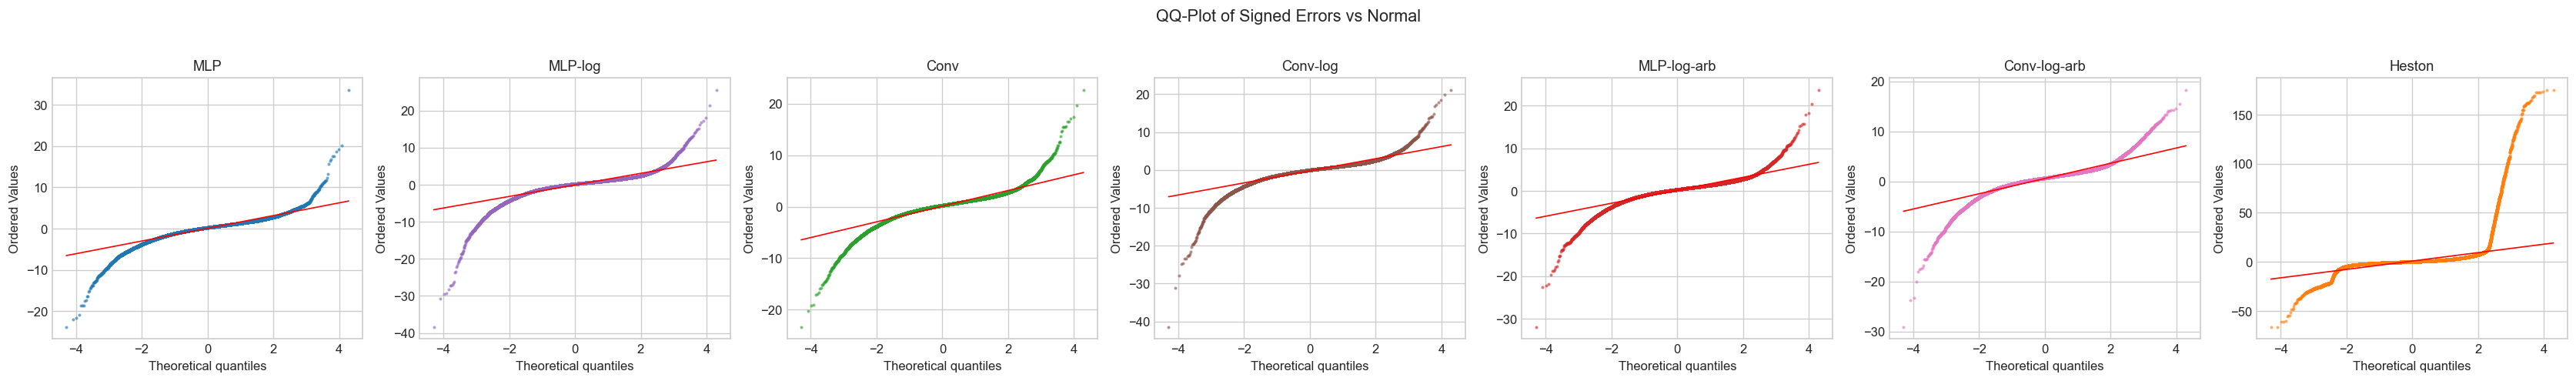

In [23]:
# ── 1b. QQ-plots (vs Normal) ──
fig, axes = plt.subplots(1, len(MODEL_NAMES), figsize=(4*len(MODEL_NAMES), 4))
for ax, name in zip(axes, MODEL_NAMES):
    e = errors[name] * 100
    stats.probplot(e, dist="norm", plot=ax)
    ax.set_title(name, fontsize=11)
    ax.get_lines()[0].set(color=COLOURS[name], markersize=1.5, alpha=0.5)
    ax.get_lines()[1].set(color="red", lw=1)
fig.suptitle("QQ-Plot of Signed Errors vs Normal", fontsize=13, y=1.02)
fig.tight_layout()
fig.savefig(OUT / "plots" / "error_qq_plots.png", bbox_inches="tight", dpi=150)
plt.show()

In [24]:
# ── 1c. Percentile table + summary statistics ──
percentiles = [50, 75, 90, 95, 99]
rows = []
for name in MODEL_NAMES:
    ae = abs_errors[name] * 100  # vol points
    se = errors[name] * 100
    row = {"Model": name,
           "Mean": se.mean(),
           "Std": se.std(),
           "Skew": float(stats.skew(se)),
           "Kurt": float(stats.kurtosis(se))}
    for p in percentiles:
        row[f"P{p}"] = np.percentile(ae, p)
    row["Max"] = ae.max()
    rows.append(row)

err_table = pd.DataFrame(rows).set_index("Model")
err_table.to_csv(OUT / "tables" / "error_distribution_stats.csv")
print("Error Distribution (absolute error in vol points):")
display(err_table.round(3))

Error Distribution (absolute error in vol points):


,Mean,Std,Skew,Kurt,P50,P75,P90,P95,P99,Max
Model,,,,,,,,,,
MLP,0.063,1.621,-1.011,12.572,0.836,1.484,2.380,3.198,5.445,33.651001
MLP-log,-0.064,1.722,-2.239,25.790,0.743,1.347,2.294,3.321,6.350,38.410999
Conv,0.099,1.610,-0.955,10.749,0.821,1.445,2.306,3.167,5.594,23.409000
Conv-log,-0.230,1.713,-1.734,20.457,0.780,1.438,2.431,3.407,6.134,41.480000
MLP-log-arb,0.152,1.626,-1.268,14.230,0.811,1.430,2.307,3.105,5.817,31.971001
Conv-log-arb,0.593,1.633,-0.989,13.423,0.980,1.612,2.417,3.240,6.046,29.111000
Heston,0.843,8.122,10.999,171.639,0.917,1.931,3.810,5.918,26.336,175.533005


## §2  Signed Bias Analysis (Mean-Error Heatmaps)

Time-averaged signed error per grid cell. Blue = model underprices, red = overprices.

C:\Users\Admin\AppData\Local\Temp\ipykernel_18668\914790627.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


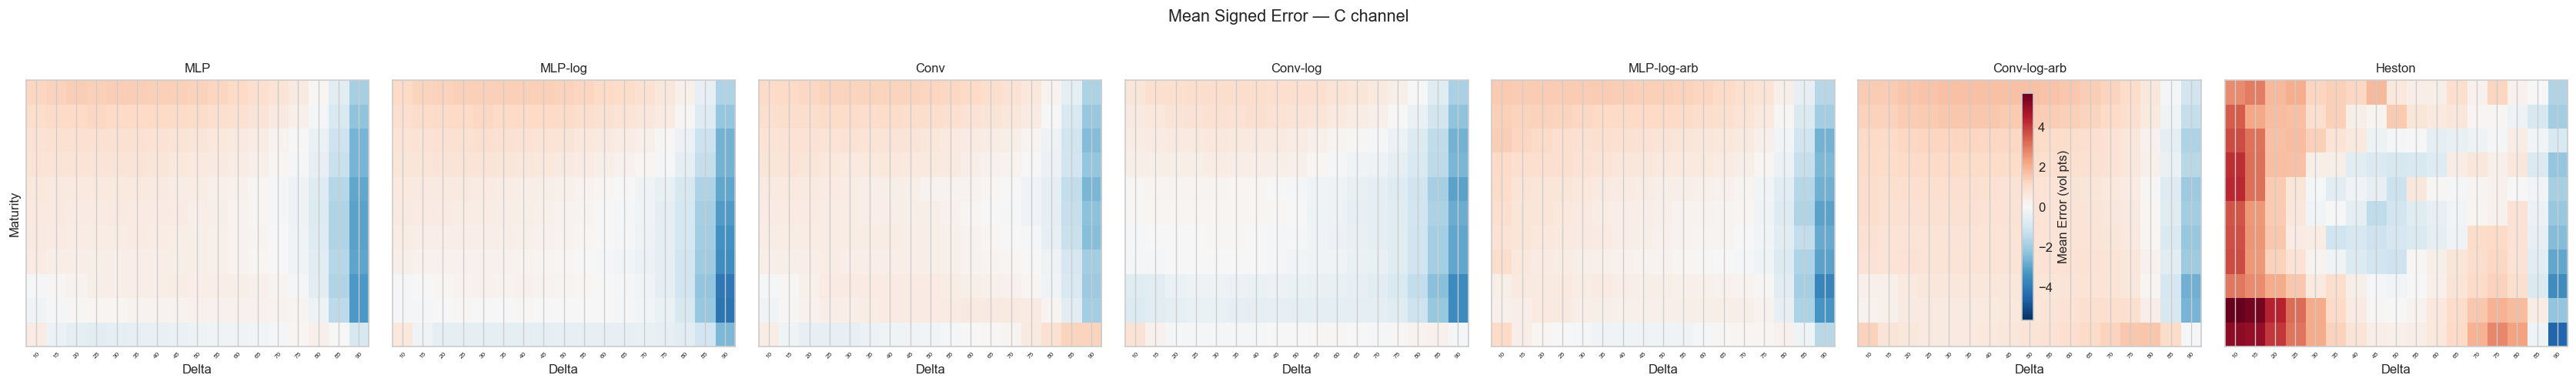

C:\Users\Admin\AppData\Local\Temp\ipykernel_18668\914790627.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


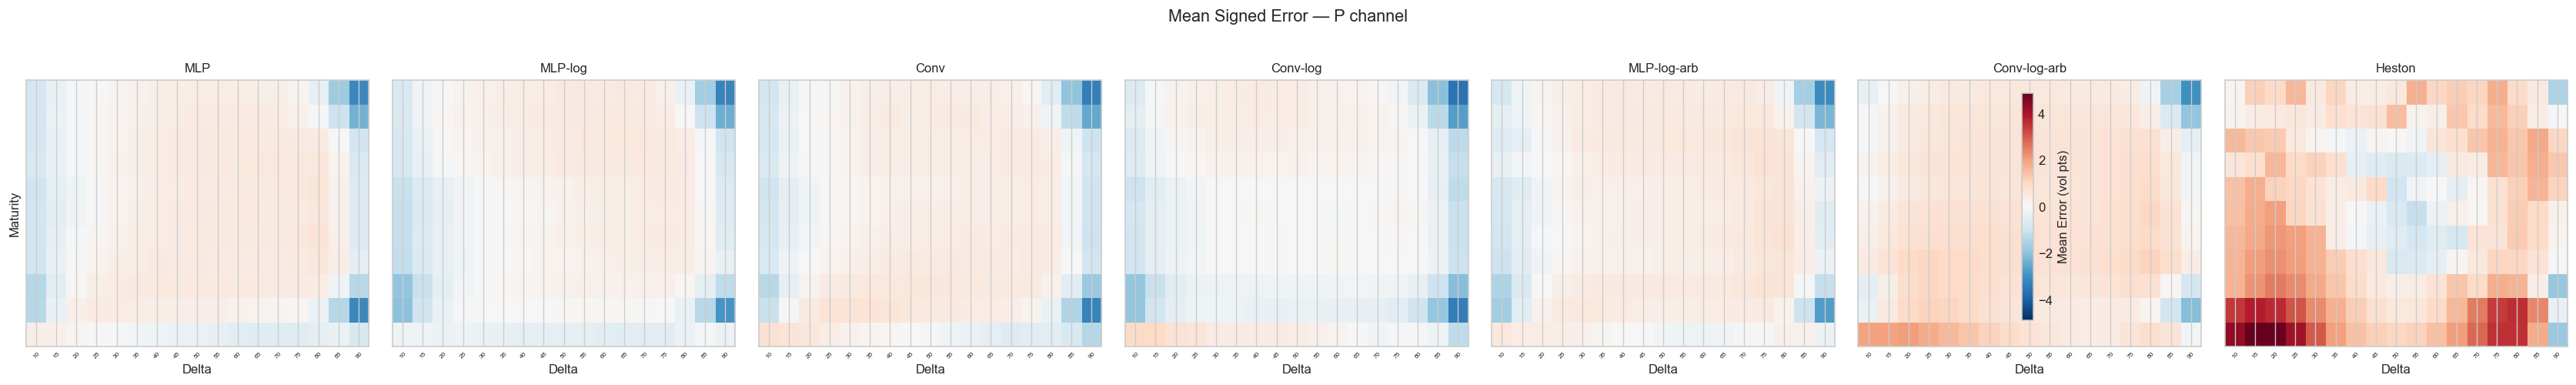

In [25]:
# ── 2. Mean signed-error heatmaps ──
# Compute per-cell mean error, NaN-aware (mask Heston NaN positions)
delta_labels = [f"{d:.0f}" for d in delta_grid * 100]
mat_labels   = [f"{d:.0f}d" for d in days_grid]

for ch_idx, ch_name in enumerate(cp_labels):
    fig, axes = plt.subplots(1, len(MODEL_NAMES), figsize=(4*len(MODEL_NAMES), 4), sharey=True)
    vmax = 0
    # Pre-compute to get symmetric colorbar
    mean_errs = {}
    for name in MODEL_NAMES:
        err_grid = models[name][:, ch_idx, :, :] - market[:, ch_idx, :, :]
        # Mask invalid cells
        cell_valid = valid_mask[:, ch_idx, :, :]
        with np.errstate(invalid="ignore"):
            me = np.where(cell_valid, err_grid, np.nan)
            mean_errs[name] = np.nanmean(me, axis=0) * 100  # vol pts
        vmax = max(vmax, np.nanmax(np.abs(mean_errs[name])))

    for ax, name in zip(axes, MODEL_NAMES):
        im = ax.imshow(mean_errs[name], cmap="RdBu_r", vmin=-vmax, vmax=vmax,
                        aspect="auto", origin="lower")
        ax.set_title(name, fontsize=10)
        ax.set_xticks(range(n_del))
        ax.set_xticklabels(delta_labels, fontsize=5, rotation=45)
        ax.set_xlabel("Delta")
        if ax is axes[0]:
            ax.set_yticks(range(n_mat))
            ax.set_yticklabels(mat_labels, fontsize=7)
            ax.set_ylabel("Maturity")
        else:
            ax.set_yticks([])

    fig.colorbar(im, ax=axes, shrink=0.8, label="Mean Error (vol pts)")
    fig.suptitle(f"Mean Signed Error — {ch_name} channel", fontsize=13, y=1.03)
    fig.tight_layout()
    fig.savefig(OUT / "plots" / f"bias_heatmap_{ch_name}.png", bbox_inches="tight", dpi=150)
    plt.show()

## §3  MAPE / Relative Error

Mean Absolute Percentage Error sliced by maturity and delta. Note: MAPE is inflated for low-IV cells (deep OTM wings); we report both overall and >20% IV subset.

C:\Users\Admin\AppData\Local\Temp\ipykernel_18668\655291479.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


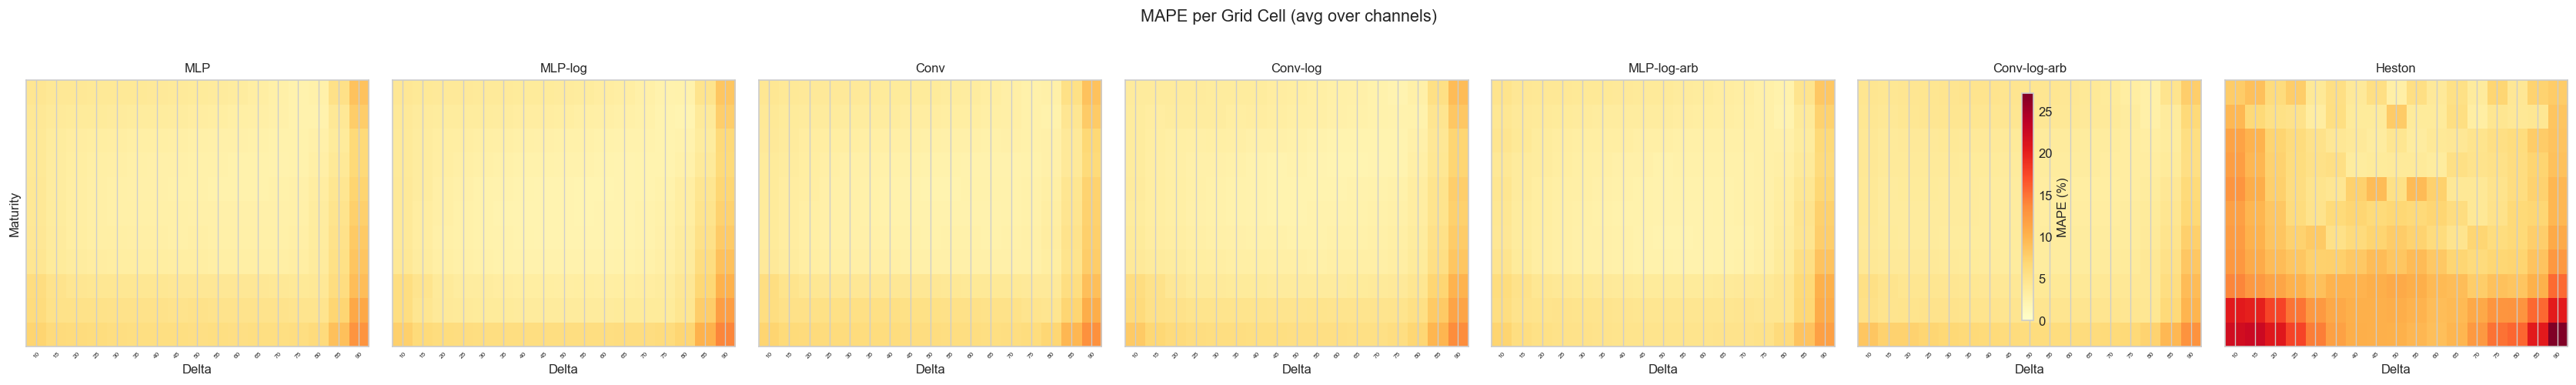

In [26]:
# ── 3a. MAPE heatmaps per model (both channels averaged) ──
def mape_grid(model_surf, market_surf, vmask):
    """MAPE per cell, percent. NaN where vmask is False."""
    with np.errstate(divide="ignore", invalid="ignore"):
        pct = np.abs(model_surf - market_surf) / np.abs(market_surf) * 100
        pct = np.where(vmask, pct, np.nan)
    return np.nanmean(pct, axis=0)  # average over dates → (C, H, W)

fig, axes = plt.subplots(1, len(MODEL_NAMES), figsize=(4*len(MODEL_NAMES), 4), sharey=True)
vmax_mape = 0
mape_grids = {}
for name in MODEL_NAMES:
    mg = mape_grid(models[name], market, valid_mask)
    mape_grids[name] = mg.mean(axis=0)  # average channels → (H, W)
    vmax_mape = max(vmax_mape, np.nanmax(mape_grids[name]))

for ax, name in zip(axes, MODEL_NAMES):
    im = ax.imshow(mape_grids[name], cmap="YlOrRd", vmin=0, vmax=min(vmax_mape, 30),
                    aspect="auto", origin="lower")
    ax.set_title(name, fontsize=10)
    ax.set_xticks(range(n_del))
    ax.set_xticklabels(delta_labels, fontsize=5, rotation=45)
    ax.set_xlabel("Delta")
    if ax is axes[0]:
        ax.set_yticks(range(n_mat))
        ax.set_yticklabels(mat_labels, fontsize=7)
        ax.set_ylabel("Maturity")
    else:
        ax.set_yticks([])

fig.colorbar(im, ax=axes, shrink=0.8, label="MAPE (%)")
fig.suptitle("MAPE per Grid Cell (avg over channels)", fontsize=13, y=1.03)
fig.tight_layout()
fig.savefig(OUT / "plots" / "mape_heatmaps.png", bbox_inches="tight", dpi=150)
plt.show()

In [27]:
# ── 3b. MAPE summary: overall vs high-IV subset ──
rows = []
for name in MODEL_NAMES:
    m_flat = market[valid_mask]
    s_flat = models[name][valid_mask]
    pct_all = np.abs(s_flat - m_flat) / np.abs(m_flat) * 100

    # High-IV subset: market IV > 0.20 (20%)
    high_mask = m_flat > 0.20
    pct_high = pct_all[high_mask]
    # Low-IV subset
    low_mask = m_flat <= 0.20
    pct_low = pct_all[low_mask]

    rows.append({
        "Model": name,
        "MAPE (all)": pct_all.mean(),
        "MAPE (IV>20%)": pct_high.mean() if high_mask.sum() > 0 else np.nan,
        "MAPE (IV≤20%)": pct_low.mean() if low_mask.sum() > 0 else np.nan,
        "N (IV>20%)": int(high_mask.sum()),
        "N (IV≤20%)": int(low_mask.sum()),
    })

mape_table = pd.DataFrame(rows).set_index("Model")
mape_table.to_csv(OUT / "tables" / "mape_summary.csv")
display(mape_table.round(2))

,MAPE (all),MAPE (IV>20%),MAPE (IV≤20%),N (IV>20%),N (IV≤20%)
Model,,,,,
MLP,4.10,3.94,9.580000,75902,2170
MLP-log,3.79,3.75,5.480000,75902,2170
Conv,4.03,3.88,9.200000,75902,2170
Conv-log,3.95,3.87,6.980000,75902,2170
MLP-log-arb,3.96,3.90,5.890000,75902,2170
Conv-log-arb,4.50,4.41,7.340000,75902,2170
Heston,8.47,8.17,18.940001,75902,2170


## §4  KS Test Per-Cell (Distributional Fit)

Two-sample Kolmogorov–Smirnov test at each grid cell: does the model's distribution of IVs match the market's? A low p-value means the model systematically distorts the distribution at that (maturity, delta) point.


In [28]:
# ── 4a. KS test per cell ──
from scipy.stats import ks_2samp

ks_pvals = {}   # name → (C, H, W) array of p-values
ks_stats = {}   # name → (C, H, W) array of KS statistics

for name in MODEL_NAMES:
    pvals = np.full((n_chan, n_mat, n_del), np.nan)
    kstats = np.full((n_chan, n_mat, n_del), np.nan)
    surf = models[name]
    for c in range(n_chan):
        for h in range(n_mat):
            for w in range(n_del):
                vmask_cell = valid_mask[:, c, h, w]
                if vmask_cell.sum() < 10:  # need enough samples
                    continue
                m_vals = market[vmask_cell, c, h, w]
                s_vals = surf[vmask_cell, c, h, w]
                stat, p = ks_2samp(m_vals, s_vals)
                kstats[c, h, w] = stat
                pvals[c, h, w] = p
    ks_pvals[name] = pvals
    ks_stats[name] = kstats
    reject_pct = 100 * np.nansum(pvals < 0.05) / np.sum(~np.isnan(pvals))
    print(f"{name:<10} cells with p < 0.05: {np.nansum(pvals < 0.05):3.0f} / "
          f"{np.sum(~np.isnan(pvals))} ({reject_pct:.1f}%)")

MLP        cells with p < 0.05: 179 / 374 (47.9%)
MLP-log    cells with p < 0.05: 160 / 374 (42.8%)
Conv       cells with p < 0.05: 186 / 374 (49.7%)
Conv-log   cells with p < 0.05: 152 / 374 (40.6%)
MLP-log-arb cells with p < 0.05: 188 / 374 (50.3%)
Conv-log-arb cells with p < 0.05: 234 / 374 (62.6%)
Heston     cells with p < 0.05: 212 / 374 (56.7%)


C:\Users\Admin\AppData\Local\Temp\ipykernel_18668\3782940763.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


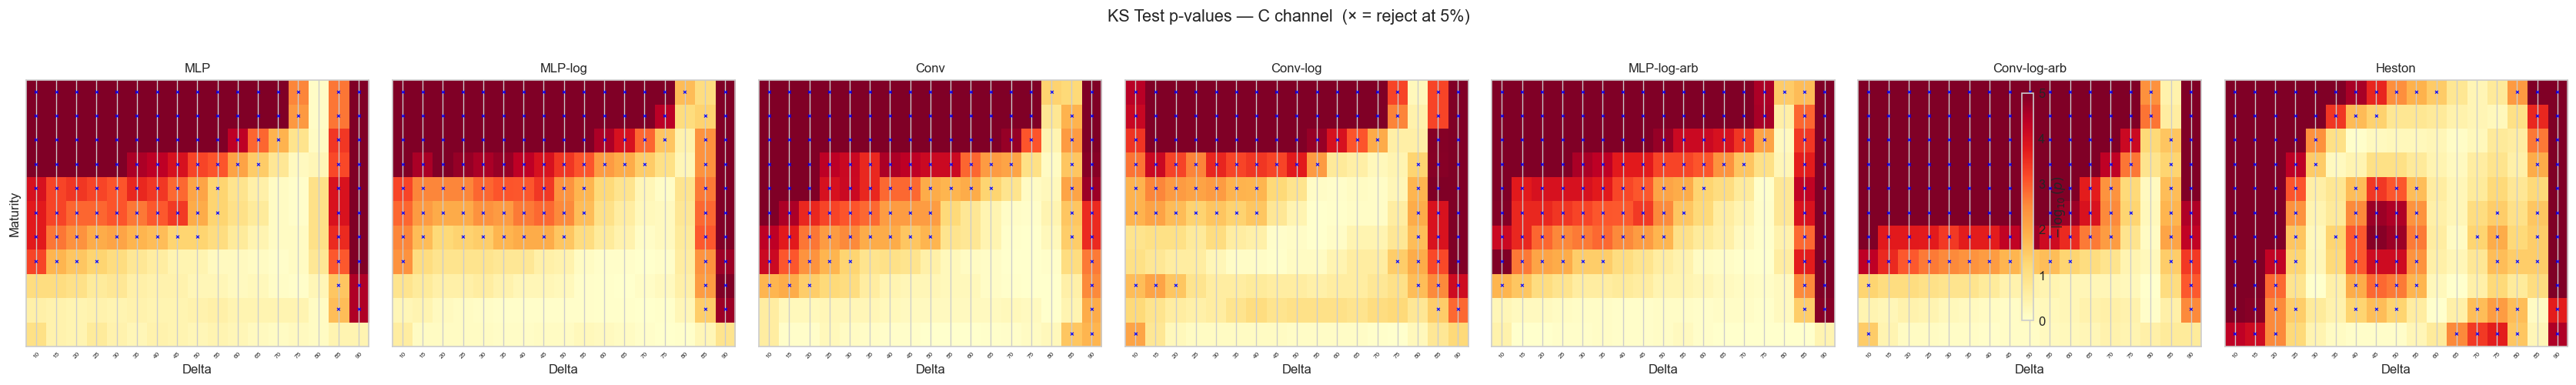

C:\Users\Admin\AppData\Local\Temp\ipykernel_18668\3782940763.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


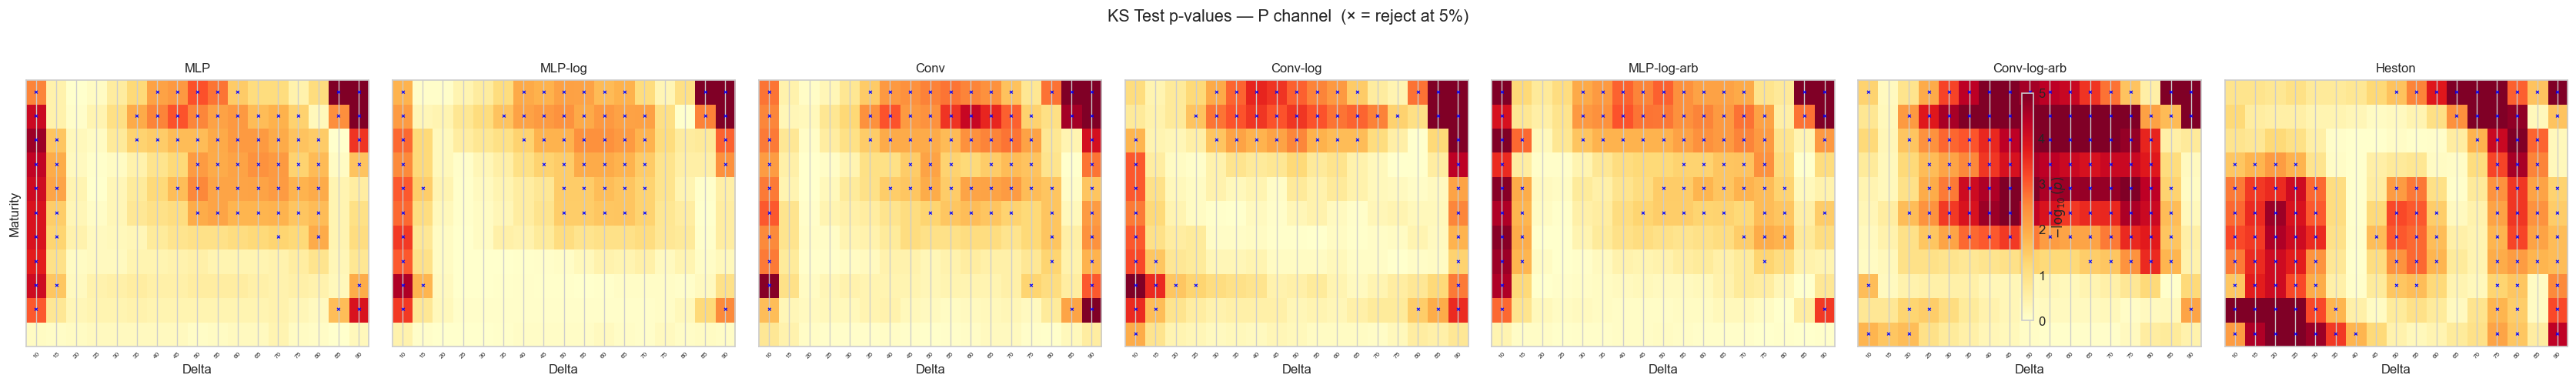

,Cells tested,Reject (p<0.05),Reject (p<0.01),Reject %,Median p-value,Mean KS stat
Model,,,,,,
MLP,374,179,129,47.8610,0.0763,0.1495
MLP-log,374,160,114,42.7807,0.1246,0.1386
Conv,374,186,134,49.7326,0.0590,0.1513
Conv-log,374,152,113,40.6417,0.1288,0.1400
MLP-log-arb,374,188,142,50.2674,0.0477,0.1500
Conv-log-arb,374,234,200,62.5668,0.0041,0.1878
Heston,374,212,155,56.6845,0.0271,0.1627


In [29]:
# ── 4b. KS p-value heatmaps ──
for ch_idx, ch_name in enumerate(cp_labels):
    fig, axes = plt.subplots(1, len(MODEL_NAMES), figsize=(4*len(MODEL_NAMES), 4), sharey=True)
    for ax, name in zip(axes, MODEL_NAMES):
        pv = ks_pvals[name][ch_idx]
        # Use log10(p) for better visual separation; clip to avoid log(0)
        log_p = -np.log10(np.clip(pv, 1e-20, 1.0))
        im = ax.imshow(log_p, cmap="YlOrRd", vmin=0, vmax=5,
                        aspect="auto", origin="lower")
        # Mark significant cells (p < 0.05 → -log10 > 1.3)
        for h in range(n_mat):
            for w in range(n_del):
                if pv[h, w] < 0.05:
                    ax.text(w, h, "×", ha="center", va="center",
                            fontsize=6, color="blue", fontweight="bold")
        ax.set_title(name, fontsize=10)
        ax.set_xticks(range(n_del))
        ax.set_xticklabels(delta_labels, fontsize=5, rotation=45)
        ax.set_xlabel("Delta")
        if ax is axes[0]:
            ax.set_yticks(range(n_mat))
            ax.set_yticklabels(mat_labels, fontsize=7)
            ax.set_ylabel("Maturity")
        else:
            ax.set_yticks([])

    fig.colorbar(im, ax=axes, shrink=0.8, label="$-\\log_{10}(p)$")
    fig.suptitle(f"KS Test p-values — {ch_name} channel  (× = reject at 5%)",
                 fontsize=13, y=1.03)
    fig.tight_layout()
    fig.savefig(OUT / "plots" / f"ks_pvalues_{ch_name}.png", bbox_inches="tight", dpi=150)
    plt.show()

# ── Summary table ──
ks_summary = []
for name in MODEL_NAMES:
    pv = ks_pvals[name]
    valid_cells = np.sum(~np.isnan(pv))
    ks_summary.append({
        "Model": name,
        "Cells tested": int(valid_cells),
        "Reject (p<0.05)": int(np.nansum(pv < 0.05)),
        "Reject (p<0.01)": int(np.nansum(pv < 0.01)),
        "Reject %": 100 * np.nansum(pv < 0.05) / valid_cells,
        "Median p-value": np.nanmedian(pv),
        "Mean KS stat": np.nanmean(ks_stats[name]),
    })
ks_df = pd.DataFrame(ks_summary).set_index("Model")
ks_df.to_csv(OUT / "tables" / "ks_test_summary.csv")
display(ks_df.round(4))

## §5  Diebold-Mariano Pairwise Significance

Tests whether the difference in squared errors between two models is statistically significant. DM > 0 means model A is *worse* than model B (larger squared errors).

DM t-statistics (positive ⇒ row model is worse):


,MLP,MLP-log,Conv,Conv-log,MLP-log-arb,Conv-log-arb,Heston
MLP,0.000,-2.134,0.063,-2.337,-0.337,-2.972,-2.141
MLP-log,2.134,0.000,2.386,-0.090,1.939,-0.322,-2.134
Conv,-0.063,-2.386,0.000,-2.510,-0.412,-3.130,-2.143
Conv-log,2.337,0.090,2.510,0.000,1.950,-0.226,-2.133
MLP-log-arb,0.337,-1.939,0.412,-1.950,0.000,-2.417,-2.140
Conv-log-arb,2.972,0.322,3.130,0.226,2.417,0.000,-2.132
Heston,2.141,2.134,2.143,2.133,2.140,2.132,0.000



DM p-values (two-sided):


,MLP,MLP-log,Conv,Conv-log,MLP-log-arb,Conv-log-arb,Heston
MLP,1.0000,0.0328,0.9500,0.0195,0.7365,0.0030,0.0323
MLP-log,0.0328,1.0000,0.0170,0.9286,0.0525,0.7475,0.0329
Conv,0.9500,0.0170,1.0000,0.0121,0.6805,0.0017,0.0321
Conv-log,0.0195,0.9286,0.0121,1.0000,0.0511,0.8210,0.0330
MLP-log-arb,0.7365,0.0525,0.6805,0.0511,1.0000,0.0156,0.0323
Conv-log-arb,0.0030,0.7475,0.0017,0.8210,0.0156,1.0000,0.0330
Heston,0.0323,0.0329,0.0321,0.0330,0.0323,0.0330,1.0000


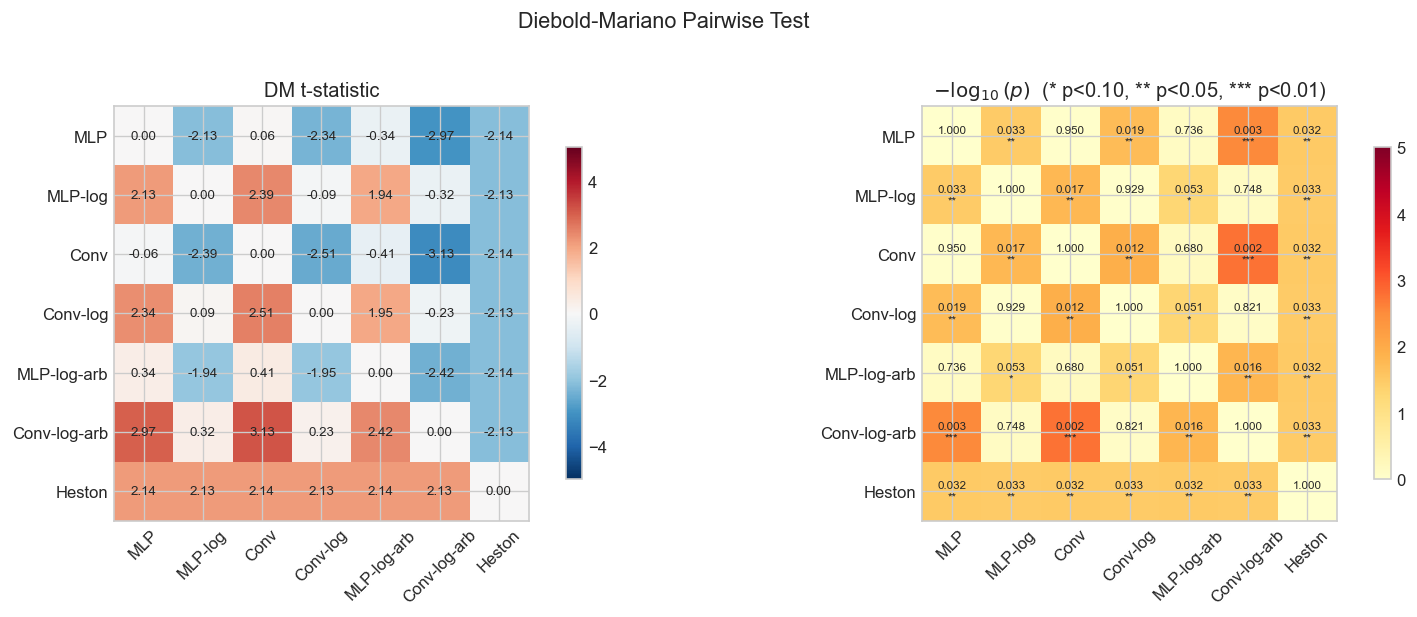

In [ ]:
# ── 5. Diebold-Mariano test (per-date, averaged over grid) ──
def diebold_mariano(e1, e2):
    """
    DM test comparing two error series (squared loss).
    Returns (t-stat, two-sided p-value).
    Positive t-stat ⇒ model 1 has *larger* squared errors.
    """
    d = e1**2 - e2**2
    d_bar = d.mean()
    n = len(d)
    # HAC variance (Newey-West with 1 lag for h=1 ahead)
    gamma_0 = np.var(d, ddof=1)
    se = np.sqrt(gamma_0 / n)
    if se < 1e-15:
        return 0.0, 1.0
    t = d_bar / se
    p = 2 * (1 - stats.norm.cdf(np.abs(t)))
    return t, p

# Compute per-date MSE for each model (average over all valid cells per date)
date_mse = {}
for name in MODEL_NAMES:
    err = models[name] - market
    # Per-date: average squared error over valid cells
    se_grid = err**2
    se_grid = np.where(valid_mask, se_grid, np.nan)
    date_mse[name] = np.nanmean(se_grid.reshape(N, -1), axis=1)  # shape (N,)

# Pairwise DM matrix
n_models = len(MODEL_NAMES)
dm_tstat = np.zeros((n_models, n_models))
dm_pval  = np.ones((n_models, n_models))

for i in range(n_models):
    for j in range(n_models):
        if i == j:
            continue
        e1 = np.sqrt(date_mse[MODEL_NAMES[i]])  # RMSE per date
        e2 = np.sqrt(date_mse[MODEL_NAMES[j]])
        t, p = diebold_mariano(e1, e2)
        dm_tstat[i, j] = t
        dm_pval[i, j] = p

# Display
dm_t_df = pd.DataFrame(dm_tstat, index=MODEL_NAMES, columns=MODEL_NAMES)
dm_p_df = pd.DataFrame(dm_pval, index=MODEL_NAMES, columns=MODEL_NAMES)

print("DM t-statistics (positive ⇒ row model is worse):")
display(dm_t_df.round(3))
print("\nDM p-values (two-sided):")
display(dm_p_df.round(4))

# Heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
im1 = ax1.imshow(dm_tstat, cmap="RdBu_r", vmin=-5, vmax=5)
ax1.set_xticks(range(n_models)); ax1.set_xticklabels(MODEL_NAMES, rotation=45, ha="right")
ax1.set_yticks(range(n_models)); ax1.set_yticklabels(MODEL_NAMES)
for i in range(n_models):
    for j in range(n_models):
        ax1.text(j, i, f"{dm_tstat[i,j]:.2f}", ha="center", va="center", fontsize=7)
ax1.set_title("DM t-statistic")
fig.colorbar(im1, ax=ax1, shrink=0.8)

# p-value heatmap with significance markers
im2 = ax2.imshow(-np.log10(np.clip(dm_pval, 1e-20, 1)), cmap="YlOrRd", vmin=0, vmax=5)
ax2.set_xticks(range(n_models)); ax2.set_xticklabels(MODEL_NAMES, rotation=45, ha="right")
ax2.set_yticks(range(n_models)); ax2.set_yticklabels(MODEL_NAMES)
for i in range(n_models):
    for j in range(n_models):
        marker = ""
        if dm_pval[i,j] < 0.01: marker = "***"
        elif dm_pval[i,j] < 0.05: marker = "**"
        elif dm_pval[i,j] < 0.10: marker = "*"
        ax2.text(j, i, f"{dm_pval[i,j]:.3f}\n{marker}", ha="center", va="center", fontsize=6)
ax2.set_title("$-\\log_{10}(p)$  (* p<0.10, ** p<0.05, *** p<0.01)")
fig.colorbar(im2, ax=ax2, shrink=0.8)

fig.suptitle("Diebold-Mariano Pairwise Test", fontsize=13, y=1.02)
fig.tight_layout()
fig.savefig(OUT / "plots" / "diebold_mariano.png", bbox_inches="tight", dpi=150)
plt.show()

dm_t_df.to_csv(OUT / "tables" / "dm_tstat.csv")
dm_p_df.to_csv(OUT / "tables" / "dm_pval.csv")

## §6  Backtesting (Exceedance Rates, Kupiec POF, Traffic Light)

Two approaches:
1. **Quantile-based:** Do the empirical tail frequencies match expected quantiles?  
2. **Fixed thresholds:** How often does |error| exceed 2, 5, 10 vol points?  

Traffic-light system (Basel-style): Green (model OK), Yellow (caution), Red (reject).


In [31]:
# ── 6a. Kupiec POF test ──
from scipy.stats import chi2

def kupiec_pof(T, N_exc, alpha):
    """
    Kupiec (1995) Proportion of Failures test.
    T: total observations, N_exc: number of exceedances, alpha: expected exceedance rate.
    Returns (LR statistic, p-value).
    """
    p_hat = N_exc / T
    if N_exc == 0:
        lr = -2 * T * np.log(1 - alpha)  # limit as p_hat → 0
        return lr, 1 - chi2.cdf(lr, 1)
    if N_exc == T:
        lr = -2 * T * np.log(alpha)
        return lr, 1 - chi2.cdf(lr, 1)
    lr = -2 * (
        N_exc * np.log(alpha / p_hat)
        + (T - N_exc) * np.log((1 - alpha) / (1 - p_hat))
    )
    return lr, 1 - chi2.cdf(lr, 1)

def traffic_light(N_exc, T, alpha):
    """
    Basel traffic-light zone based on exceedance count.
    Green: ≤ expected + 1σ, Yellow: ≤ expected + 2σ, Red: above.
    """
    expected = T * alpha
    std = np.sqrt(T * alpha * (1 - alpha))
    if N_exc <= expected + std:
        return "🟢 Green"
    elif N_exc <= expected + 2 * std:
        return "🟡 Yellow"
    else:
        return "🔴 Red"

# ── 6b. Quantile-based backtesting ──
alphas = [0.01, 0.025, 0.05]
print("=== Quantile-Based Backtesting ===\n")

qt_rows = []
for name in MODEL_NAMES:
    ae = abs_errors[name]  # flat array of absolute errors at valid cells
    T = len(ae)
    for alpha in alphas:
        threshold = np.quantile(ae, 1 - alpha)  # empirical threshold from pooled data
        # But for backtesting we need per-date exceedances
        # Use per-date mean absolute error, then check if it exceeds the date-level quantile
        date_mae = np.array([
            np.nanmean(np.abs(models[name][t][valid_mask[t]] - market[t][valid_mask[t]]))
            for t in range(N)
        ])
        thr = np.quantile(date_mae, 1 - alpha)
        N_exc = (date_mae > thr).sum()
        expected = N * alpha
        lr, pval = kupiec_pof(N, N_exc, alpha)
        tl = traffic_light(N_exc, N, alpha)
        qt_rows.append({
            "Model": name, "α": f"{alpha:.1%}",
            "Threshold (vol pts)": thr * 100,
            "Exceedances": N_exc, "Expected": expected,
            "Exc. Rate": N_exc / N,
            "Kupiec LR": lr, "Kupiec p": pval,
            "Traffic Light": tl,
        })

qt_df = pd.DataFrame(qt_rows)
display(qt_df.set_index(["Model", "α"]))
qt_df.to_csv(OUT / "tables" / "backtest_quantile.csv", index=False)

=== Quantile-Based Backtesting ===



Threshold (vol pts)  Exceedances  Expected  Exc. Rate  \
Model        α                                                             
MLP          1.0%             2.099356            3      2.10   0.014286   
             2.5%             1.844834            6      5.25   0.028571   
             5.0%             1.718339           11     10.50   0.052381   
MLP-log      1.0%             2.149384            3      2.10   0.014286   
             2.5%             1.809212            6      5.25   0.028571   
             5.0%             1.601856           11     10.50   0.052381   
Conv         1.0%             1.788037            3      2.10   0.014286   
             2.5%             1.680536            6      5.25   0.028571   
             5.0%             1.550067           11     10.50   0.052381   
Conv-log     1.0%             2.252934            3      2.10   0.014286   
             2.5%             1.946372            6      5.25   0.028571   
             5.0%             1.707641           11     10.50   0.052381   
MLP-log-arb  1.0%             1.862963            3      2.10   0.014286   
             2.5%             1.807243            6      5.25   0.028571   
             5.0%             1.629760           11     10.50   0.052381   
Conv-log-arb 1.0%             2.531896            3      2.10   0.014286   
             2.5%             2.103944            6      5.25   0.028571   
             5.0%             1.913294           11     10.50   0.052381   
Heston       1.0%            46.642063            3      2.10   0.014286   
             2.5%             9.789282            6      5.25   0.028571   
             5.0%             3.190957           11     10.50   0.052381   

                   Kupiec LR  Kupiec p Traffic Light  
Model        α                                        
MLP          1.0%   0.343951  0.557557       🟢 Green  
             2.5%   0.105127  0.745761       🟢 Green  
             5.0%   0.024695  0.875131       🟢 Green  
MLP-log      1.0%   0.343951  0.557557       🟢 Green  
             2.5%   0.105127  0.745761       🟢 Green  
             5.0%   0.024695  0.875131       🟢 Green  
Conv         1.0%   0.343951  0.557557       🟢 Green  
             2.5%   0.105127  0.745761       🟢 Green  
             5.0%   0.024695  0.875131       🟢 Green  
Conv-log     1.0%   0.343951  0.557557       🟢 Green  
             2.5%   0.105127  0.745761       🟢 Green  
             5.0%   0.024695  0.875131       🟢 Green  
MLP-log-arb  1.0%   0.343951  0.557557       🟢 Green  
             2.5%   0.105127  0.745761       🟢 Green  
             5.0%   0.024695  0.875131       🟢 Green  
Conv-log-arb 1.0%   0.343951  0.557557       🟢 Green  
             2.5%   0.105127  0.745761       🟢 Green  
             5.0%   0.024695  0.875131       🟢 Green  
Heston       1.0%   0.343951  0.557557       🟢 Green  
             2.5%   0.105127  0.745761       🟢 Green  
             5.0%   0.024695  0.875131       🟢 Green

=== Fixed-Threshold Backtesting ===



Exceedances   Rate
Model        Threshold (vp)                    
MLP          2                         4   1.9%
             5                         0   0.0%
             10                        0   0.0%
MLP-log      2                         3   1.4%
             5                         0   0.0%
             10                        0   0.0%
Conv         2                         1   0.5%
             5                         0   0.0%
             10                        0   0.0%
Conv-log     2                         3   1.4%
             5                         0   0.0%
             10                        0   0.0%
MLP-log-arb  2                         2   1.0%
             5                         0   0.0%
             10                        0   0.0%
Conv-log-arb 2                         9   4.3%
             5                         0   0.0%
             10                        0   0.0%
Heston       2                        35  16.7%
             5                         8   3.8%
             10                        6   2.9%

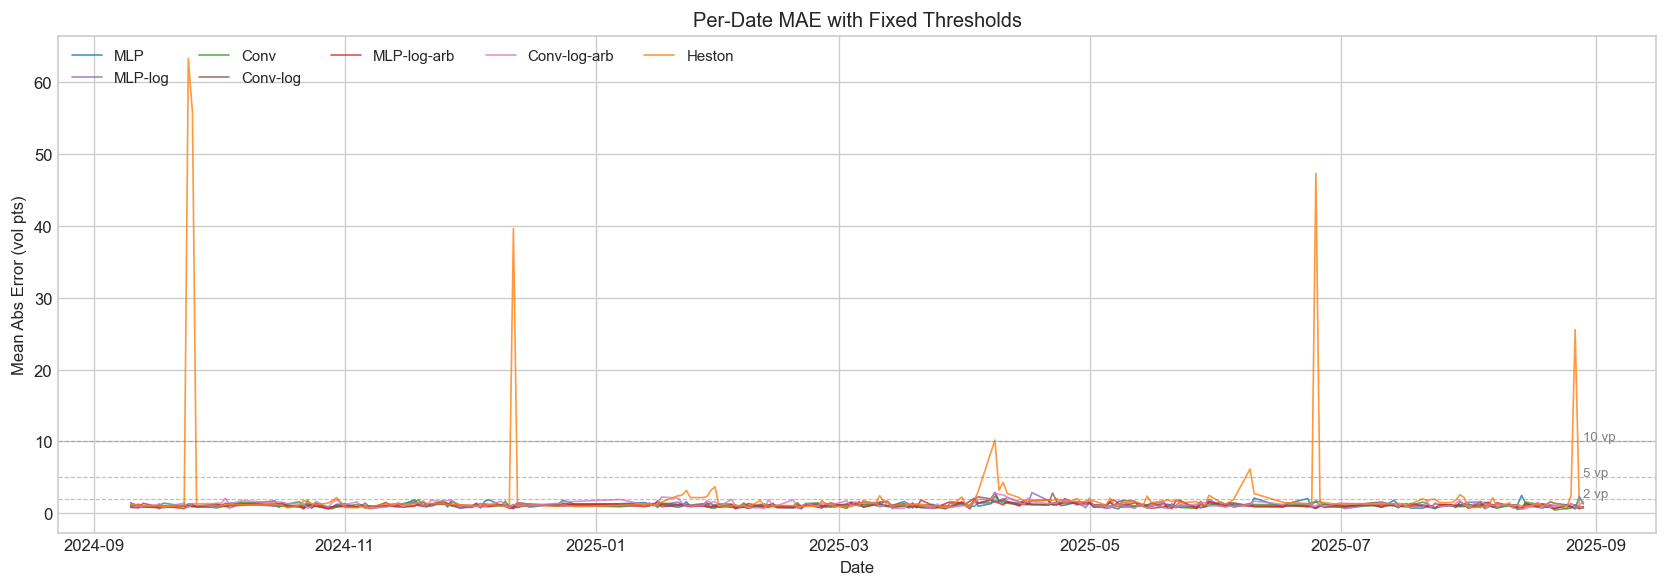

In [ ]:
# ── 6c. Fixed-threshold backtesting ──
thresholds_vp = [2, 5, 10]  # vol points
print("=== Fixed-Threshold Backtesting ===\n")

ft_rows = []
for name in MODEL_NAMES:
    date_mae = np.array([
        np.nanmean(np.abs(models[name][t][valid_mask[t]] - market[t][valid_mask[t]]))
        for t in range(N)
    ]) * 100  # → vol points
    for thr in thresholds_vp:
        N_exc = (date_mae > thr).sum()
        rate = N_exc / N
        ft_rows.append({
            "Model": name, "Threshold (vp)": thr,
            "Exceedances": N_exc, "Rate": f"{rate:.1%}",
        })

ft_df = pd.DataFrame(ft_rows)
display(ft_df.set_index(["Model", "Threshold (vp)"]))
ft_df.to_csv(OUT / "tables" / "backtest_fixed_threshold.csv", index=False)

# ── 6d. Visual: per-date MAE time series with threshold bands ──
fig, ax = plt.subplots(figsize=(14, 5))
for name in MODEL_NAMES:
    date_mae = np.array([
        np.nanmean(np.abs(models[name][t][valid_mask[t]] - market[t][valid_mask[t]]))
        for t in range(N)
    ]) * 100
    ax.plot(aligned_dates, date_mae, color=COLOURS[name], label=name, alpha=0.8, lw=1)
for thr in thresholds_vp:
    ax.axhline(thr, color="grey", ls="--", lw=0.7, alpha=0.5)
    ax.text(aligned_dates.iloc[-1], thr + 0.2, f"{thr} vp", fontsize=8, color="grey")
ax.set_ylabel("Mean Abs Error (vol pts)")
ax.set_xlabel("Date")
ax.set_title("Per-Date MAE with Fixed Thresholds")
ax.legend(fontsize=8, ncol=4, loc="upper left")
fig.tight_layout()
fig.savefig(OUT / "plots" / "backtest_timeseries.png", bbox_inches="tight", dpi=150)
plt.show()

## §7  Regime Conditioning

Split analysis by volatility regime. ATM IV (delta ≈ 0.50, mid-maturity) as a proxy for "market vol level". Terciles: low / medium / high vol.

In [33]:
# ── 7a. Compute ATM IV per date (proxy: call channel, δ=0.50, ~182-day maturity) ──
# Find delta=0.50 index and mid-maturity index
atm_delta_idx = np.argmin(np.abs(delta_grid - 0.50))
mid_mat_idx   = np.argmin(np.abs(days_grid - 182))
print(f"ATM proxy: delta[{atm_delta_idx}]={delta_grid[atm_delta_idx]:.2f}, "
      f"maturity[{mid_mat_idx}]={days_grid[mid_mat_idx]:.0f}d")

atm_iv = market[:, 0, mid_mat_idx, atm_delta_idx]  # call channel
print(f"ATM IV range: [{atm_iv.min()*100:.1f}%, {atm_iv.max()*100:.1f}%]")

# Tercile boundaries
t1, t2 = np.percentile(atm_iv, [33.3, 66.7])
regime_labels = np.where(atm_iv <= t1, "Low", np.where(atm_iv <= t2, "Mid", "High"))
print(f"Terciles: Low ≤ {t1*100:.1f}%, Mid ≤ {t2*100:.1f}%, High > {t2*100:.1f}%")
print(f"Counts: Low={np.sum(regime_labels=='Low')}, Mid={np.sum(regime_labels=='Mid')}, "
      f"High={np.sum(regime_labels=='High')}")

ATM proxy: delta[8]=0.50, maturity[6]=182d
ATM IV range: [21.7%, 41.0%]
Terciles: Low ≤ 23.8%, Mid ≤ 26.7%, High > 26.7%
Counts: Low=70, Mid=70, High=70


MAE (vp)               RMSE (vp)               
Regime           High    Low    Mid      High     Low    Mid
Model                                                       
Conv            1.174  1.157  1.012     1.675   1.695  1.460
Conv-log        1.299  1.078  1.025     1.983   1.618  1.553
Conv-log-arb    1.294  1.220  1.215     1.898   1.695  1.605
Heston          2.491  2.641  1.711     7.185  11.357  4.500
MLP             1.175  1.141  1.077     1.684   1.674  1.503
MLP-log         1.277  1.002  0.998     2.045   1.575  1.498
MLP-log-arb     1.242  1.032  1.067     1.813   1.518  1.550

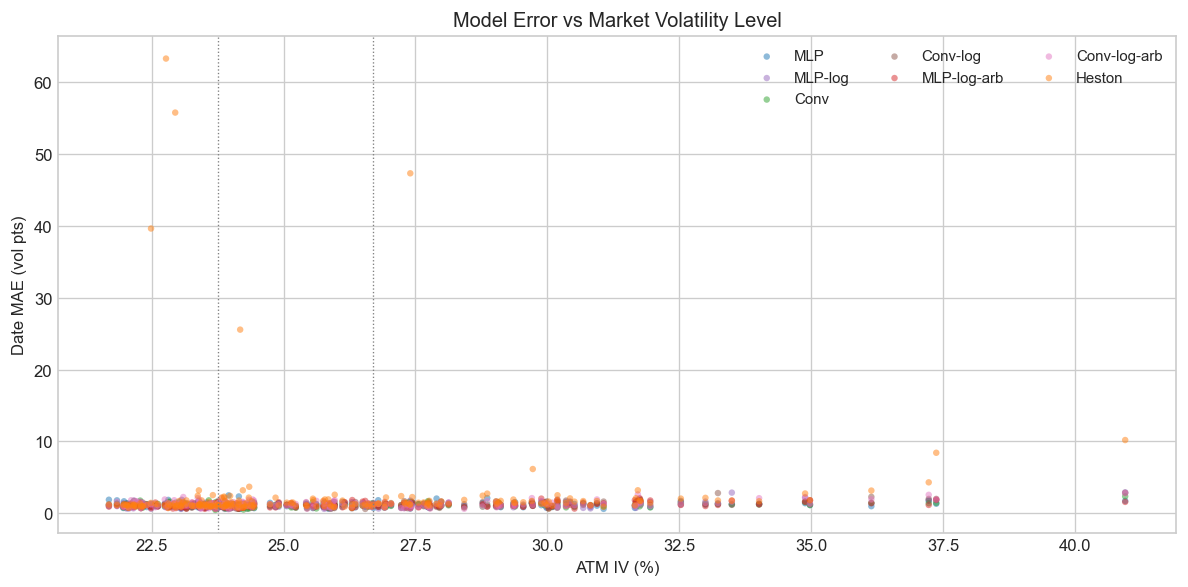

In [ ]:
# ── 7b. MAE by regime ──
regime_rows = []
for name in MODEL_NAMES:
    for regime in ["Low", "Mid", "High"]:
        idx = np.where(regime_labels == regime)[0]
        surf_sub = models[name][idx]
        mkt_sub = market[idx]
        vm_sub = valid_mask[idx]
        ae = np.abs(surf_sub[vm_sub] - mkt_sub[vm_sub])
        regime_rows.append({
            "Model": name, "Regime": regime,
            "MAE (vp)": ae.mean() * 100,
            "RMSE (vp)": np.sqrt((ae**2).mean()) * 100,
            "P95 (vp)": np.percentile(ae, 95) * 100,
            "N dates": len(idx),
        })

regime_df = pd.DataFrame(regime_rows)
regime_pivot = regime_df.pivot_table(
    index="Model", columns="Regime",
    values=["MAE (vp)", "RMSE (vp)", "P95 (vp)"],
)[["MAE (vp)", "RMSE (vp)"]].round(3)
regime_pivot.to_csv(OUT / "tables" / "regime_mae.csv")
display(regime_pivot)

# ── 7c. Scatter: per-date MAE vs ATM IV ──
fig, ax = plt.subplots(figsize=(12, 5))
for name in MODEL_NAMES:
    date_mae = np.array([
        np.nanmean(np.abs(models[name][t][valid_mask[t]] - market[t][valid_mask[t]]))
        for t in range(N)
    ]) * 100
    ax.scatter(atm_iv * 100, date_mae, color=COLOURS[name], label=name,
               alpha=0.5, s=15, edgecolors="none")
ax.set_xlabel("ATM IV (%)")
ax.set_ylabel("Date MAE (vol pts)")
ax.set_title("Model Error vs Market Volatility Level")
ax.axvline(t1 * 100, color="grey", ls=":", lw=0.8)
ax.axvline(t2 * 100, color="grey", ls=":", lw=0.8)
ax.legend(fontsize=8, ncol=4)
fig.tight_layout()
fig.savefig(OUT / "plots" / "regime_scatter.png", bbox_inches="tight", dpi=150)
plt.show()

## §8  Arbitrage Violation Counting

1. **Calendar spread** — total variance $\sigma^2 T$ must be non-decreasing in $T$ (for each delta). Violation ⇒ negative calendar spread.
2. **Butterfly spread** — IV must be convex in delta (for each maturity). Second finite difference < 0 ⇒ butterfly arbitrage.

We count violations for all 5 models AND the market (baseline).

In [35]:
# ── 8. Arbitrage violation counts ──
def count_calendar_violations(surfaces, days, valid=None):
    """
    Calendar spread: σ²T must be non-decreasing along maturity axis.
    surfaces: (N, C, H, W) with H=maturity.
    Returns total violation count and per-date array.
    """
    T = np.array(days) / 365.0  # annualised
    T = T[np.newaxis, np.newaxis, :, np.newaxis]  # (1, 1, H, 1)
    total_var = surfaces**2 * T  # (N, C, H, W)
    diff = np.diff(total_var, axis=2)  # (N, C, H-1, W)
    if valid is not None:
        # mask: only count where both adjacent maturities are valid
        v1 = valid[:, :, :-1, :]
        v2 = valid[:, :, 1:, :]
        vmask = v1 & v2
        violations = (diff[vmask] < -1e-8)
    else:
        violations = (diff < -1e-8)
    return int(violations.sum()), violations

def count_butterfly_violations(surfaces, valid=None):
    """
    Butterfly: IV must be convex in delta ⇒ second difference ≥ 0.
    surfaces: (N, C, H, W) with W=delta.
    """
    d2 = np.diff(surfaces, n=2, axis=3)  # (N, C, H, W-2)
    if valid is not None:
        v1 = valid[:, :, :, :-2]
        v2 = valid[:, :, :, 1:-1]
        v3 = valid[:, :, :, 2:]
        vmask = v1 & v2 & v3
        violations = (d2[vmask] < -1e-8)
    else:
        violations = (d2 < -1e-8)
    return int(violations.sum()), violations

# Count for all models + market
arb_rows = []
all_surfs = {**models, "Market": market}
for name, surf in all_surfs.items():
    vm = valid_mask if name != "Market" else np.ones_like(valid_mask)
    cal_count, _ = count_calendar_violations(surf, days_grid, vm)
    but_count, _ = count_butterfly_violations(surf, vm)
    # Total possible comparisons
    cal_total = vm[:, :, :-1, :].sum() if name != "Market" else N * n_chan * (n_mat - 1) * n_del
    but_total = vm[:, :, :, :-2].sum() if name != "Market" else N * n_chan * n_mat * (n_del - 2)
    arb_rows.append({
        "Surface": name,
        "Calendar violations": cal_count,
        "Calendar total pairs": int(cal_total) if isinstance(cal_total, (int, np.integer)) else int(cal_total),
        "Calendar rate %": 100 * cal_count / max(cal_total, 1),
        "Butterfly violations": but_count,
        "Butterfly total triples": int(but_total) if isinstance(but_total, (int, np.integer)) else int(but_total),
        "Butterfly rate %": 100 * but_count / max(but_total, 1),
    })

arb_df = pd.DataFrame(arb_rows).set_index("Surface")
arb_df.to_csv(OUT / "tables" / "arbitrage_violations.csv")
display(arb_df.round(3))

,Calendar violations,Calendar total pairs,Calendar rate %,Butterfly violations,Butterfly total triples,Butterfly rate %
Surface,,,,,,
MLP,0,71060,0.000,18885,68889,27.414
MLP-log,0,71060,0.000,16167,68889,23.468
Conv,0,71060,0.000,16391,68889,23.793
Conv-log,0,71060,0.000,16787,68889,24.368
MLP-log-arb,0,71060,0.000,4029,68889,5.849
Conv-log-arb,0,71060,0.000,754,68889,1.095
Heston,260,71060,0.366,802,68889,1.164
Market,16,71400,0.022,1573,69300,2.270


## §9  Surface Smoothness

Measuring how "smooth" each model's surfaces are, using:
1. **Discrete Laplacian** $\|\nabla^2 \sigma\|$ — lower = smoother.
2. **Total Variation** $\text{TV} = \sum |\Delta_x \sigma| + |\Delta_y \sigma|$ — lower = smoother.

Market surfaces serve as the baseline.

Surface Smoothness (lower = smoother):


,Laplacian |∇²σ|,Total Variation
Surface,,
MLP-log-arb,0.007455,0.014954
Conv-log-arb,0.007518,0.015772
Conv,0.007758,0.015394
Conv-log,0.008300,0.015452
MLP-log,0.008306,0.015056
MLP,0.008569,0.015161
Market,0.011032,0.018237
Heston,0.015062,0.023097


C:\Users\Admin\AppData\Local\Temp\ipykernel_18668\2233990488.py:44: UserWarning: Glyph 8711 (\N{NABLA}) missing from font(s) Arial.
  fig.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_18668\2233990488.py:45: UserWarning: Glyph 8711 (\N{NABLA}) missing from font(s) Arial.
  fig.savefig(OUT / "plots" / "smoothness.png", bbox_inches="tight", dpi=150)
c:\Users\Admin\OneDrive\Desktop\Fifth Year\Computer Science\CS4490 Thesis\Codebase\Thesis\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8711 (\N{NABLA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


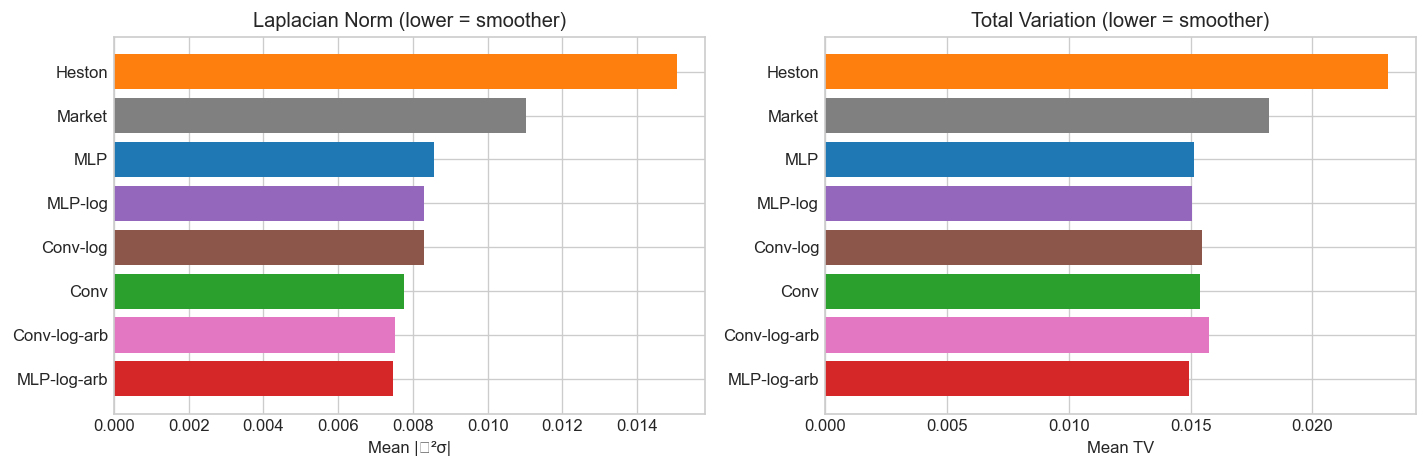

In [36]:
# ── 9. Surface smoothness metrics ──
def laplacian_norm(surfaces):
    """
    Discrete Laplacian: ∇²σ at interior points.
    Returns mean |∇²σ| over all dates, channels, interior cells.
    """
    # Laplacian along maturity (axis=2)
    lap_mat = np.diff(surfaces, n=2, axis=2)  # (N, C, H-2, W)
    # Laplacian along delta (axis=3)
    lap_del = np.diff(surfaces, n=2, axis=3)  # (N, C, H, W-2)
    return np.nanmean(np.abs(lap_mat)) + np.nanmean(np.abs(lap_del))

def total_variation(surfaces):
    """
    Anisotropic total variation: sum of absolute first differences.
    """
    dx = np.diff(surfaces, axis=2)  # maturity direction
    dy = np.diff(surfaces, axis=3)  # delta direction
    return np.nanmean(np.abs(dx)) + np.nanmean(np.abs(dy))

smooth_rows = []
all_surfs_smooth = {**models, "Market": market}
for name, surf in all_surfs_smooth.items():
    lap = laplacian_norm(surf)
    tv = total_variation(surf)
    smooth_rows.append({"Surface": name, "Laplacian |∇²σ|": lap, "Total Variation": tv})

smooth_df = pd.DataFrame(smooth_rows).set_index("Surface")
smooth_df = smooth_df.sort_values("Laplacian |∇²σ|")
smooth_df.to_csv(OUT / "tables" / "smoothness.csv")
print("Surface Smoothness (lower = smoother):")
display(smooth_df.round(6))

# Bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
names = smooth_df.index.tolist()
colors = [COLOURS.get(n, "grey") for n in names]
ax1.barh(names, smooth_df["Laplacian |∇²σ|"], color=colors)
ax1.set_xlabel("Mean |∇²σ|")
ax1.set_title("Laplacian Norm (lower = smoother)")
ax2.barh(names, smooth_df["Total Variation"], color=colors)
ax2.set_xlabel("Mean TV")
ax2.set_title("Total Variation (lower = smoother)")
fig.tight_layout()
fig.savefig(OUT / "plots" / "smoothness.png", bbox_inches="tight", dpi=150)
plt.show()

## Summary

All validation artifacts saved to `artifacts/validation/arb_penalty/`:
- `plots/` — PNG figures for thesis
- `tables/` — CSV tables for LaTeX import

**Models validated:** MLP, MLP-log, Conv, Conv-log, MLP-log-arb, Conv-log-arb, Heston (7 total)

**Key outputs:**
| File | Content |
|------|---------|
| `error_distribution_stats.csv` | Percentile table (P50–P99, max, skew, kurtosis) |
| `mape_summary.csv` | MAPE overall vs high/low IV subsets |
| `ks_test_summary.csv` | KS rejection rates per model |
| `dm_tstat.csv`, `dm_pval.csv` | Diebold-Mariano pairwise matrices |
| `backtest_quantile.csv` | Kupiec POF + traffic light |
| `backtest_fixed_threshold.csv` | Fixed threshold exceedance rates |
| `regime_mae.csv` | MAE by vol regime tercile |
| `arbitrage_violations.csv` | Calendar + butterfly violation counts |
| `smoothness.csv` | Laplacian + TV rankings |

**Key comparison: baseline vs arb-penalized variants**
- MLP-log vs MLP-log-arb: butterfly violation reduction?
- Conv-log vs Conv-log-arb: butterfly violation reduction?
- MAE/RMSE trade-off: did arb penalty hurt reconstruction accuracy?